# Introduction

Our project focuses on predicting strokes within humans. The dataset is extensive, containing over 5100 examples and including features such as gender, age, hypertenstion, heart disease, marriage, job occupation, residence type, glucose levels, bmi, and smoking status. These features will be used to make a binary prediction of whether that person has had a stroke or not. This is very interesting as our analysis describes what factors contribute most and least to strokes. This information can be informative regarding medical and health practices.

# Setup

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch

In [208]:
# Initialize DataFrame
df = pd.read_csv('healthcare-dataset-stroke-data.csv').drop('id', axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Initial Analysis

In [209]:
# Dataset Overview
print("Dataset Shape:", df.shape)

print("\nColumn Data Types:")
print(df.dtypes)

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())
print(f"\nMissing BMI: {df['bmi'].isnull().sum()} ({df['bmi'].isnull().sum()/len(df)*100:.2f}%)")

Dataset Shape: (5110, 11)

Column Data Types:
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Basic Statistics:
               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.0

Stroke Distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Stroke Percentage:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


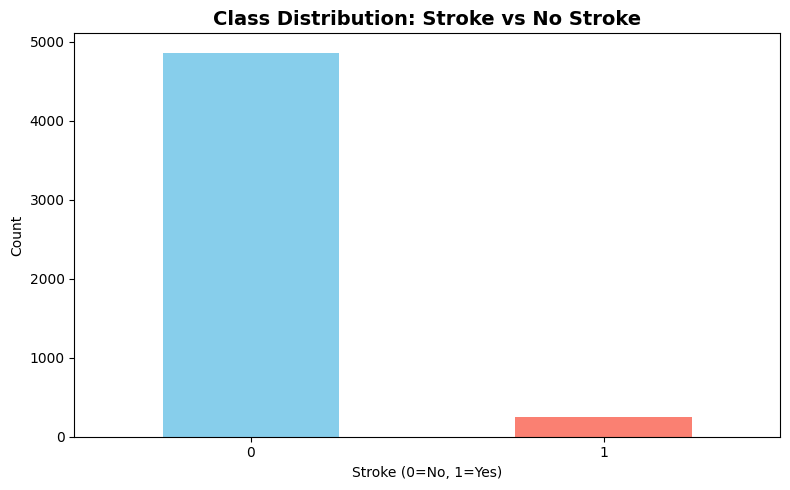

In [210]:
# Check class balance (Target variable)
print("Stroke Distribution:")
print(df['stroke'].value_counts())
print("\nStroke Percentage:")
print(df['stroke'].value_counts(normalize=True) * 100)

# Visualize class balance
plt.figure(figsize=(8, 5))
df['stroke'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Stroke vs No Stroke', fontsize=14, fontweight='bold')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

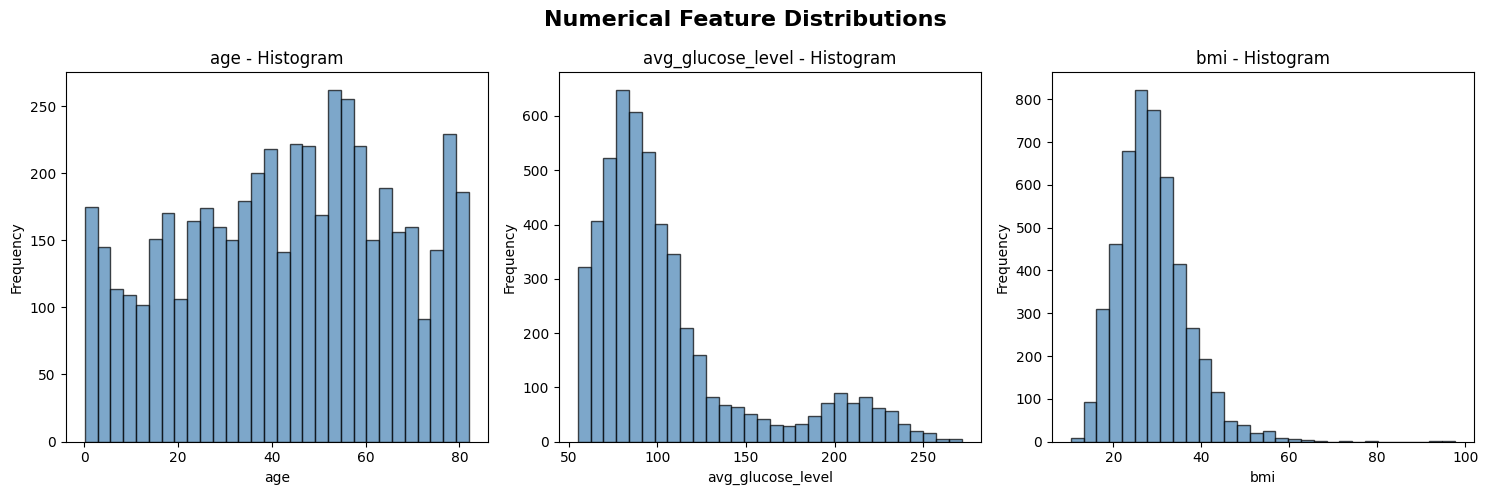

In [211]:
# Numerical Feature Distributions
numerical_features = ['age', 'avg_glucose_level', 'bmi']
num_features = len(numerical_features)
fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5))
fig.suptitle('Numerical Feature Distributions', fontsize=16, fontweight='bold')

if num_features == 1:
    axes = [axes] 

for idx, feature in enumerate(numerical_features):
    axes[idx].hist(df[feature].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature} - Histogram')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



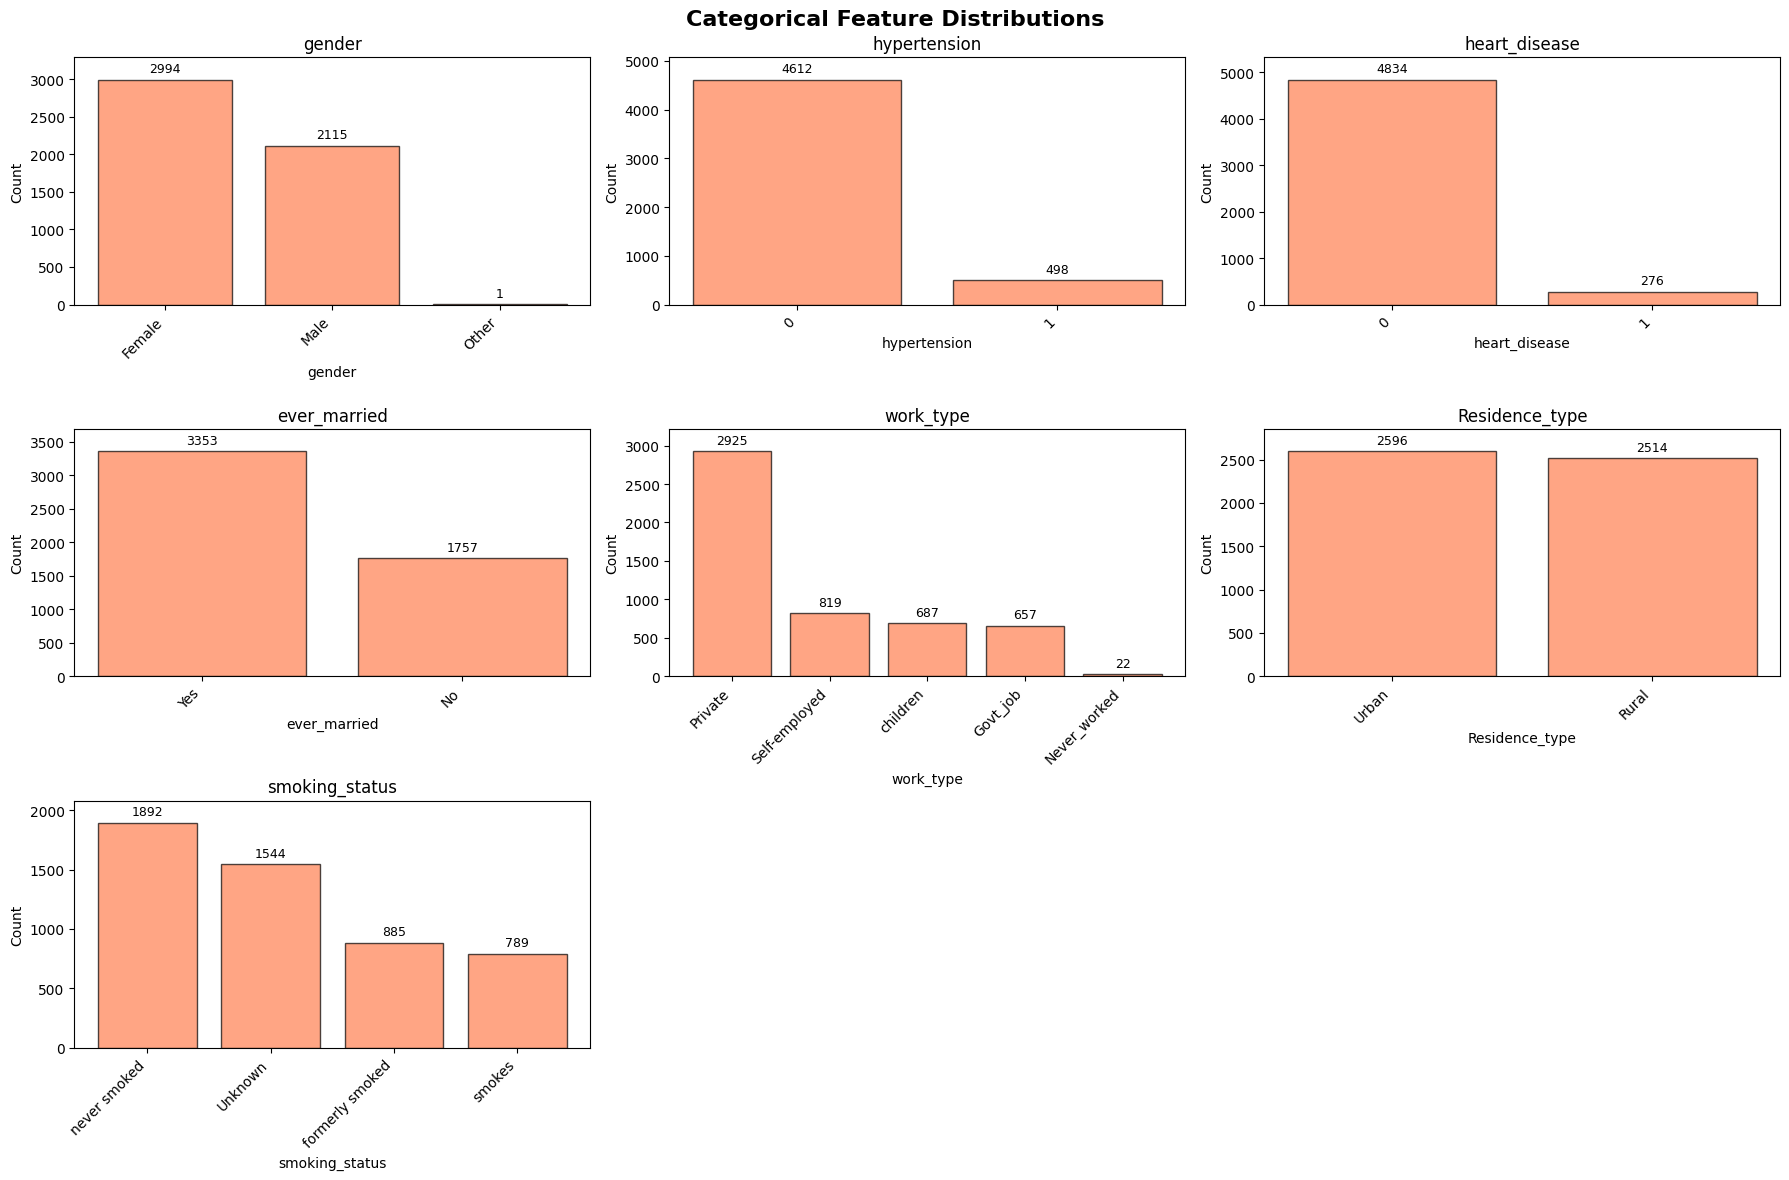

In [212]:
# Categorical Feature Distributions
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Categorical Feature Distributions', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    counts = df[feature].value_counts()
    axes[idx].bar(range(len(counts)), counts.values, color='coral', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(range(len(counts)))
    axes[idx].set_xticklabels(counts.index, rotation=45, ha='right')
    
    # Add value labels on bars
    max_val = max(counts.values)
    for i, v in enumerate(counts.values):
        axes[idx].text(i, v + max_val * 0.02, str(v), ha='center', va='bottom', fontsize=9)
    
    # Add some padding to y-axis
    axes[idx].set_ylim(0, max_val * 1.1)

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


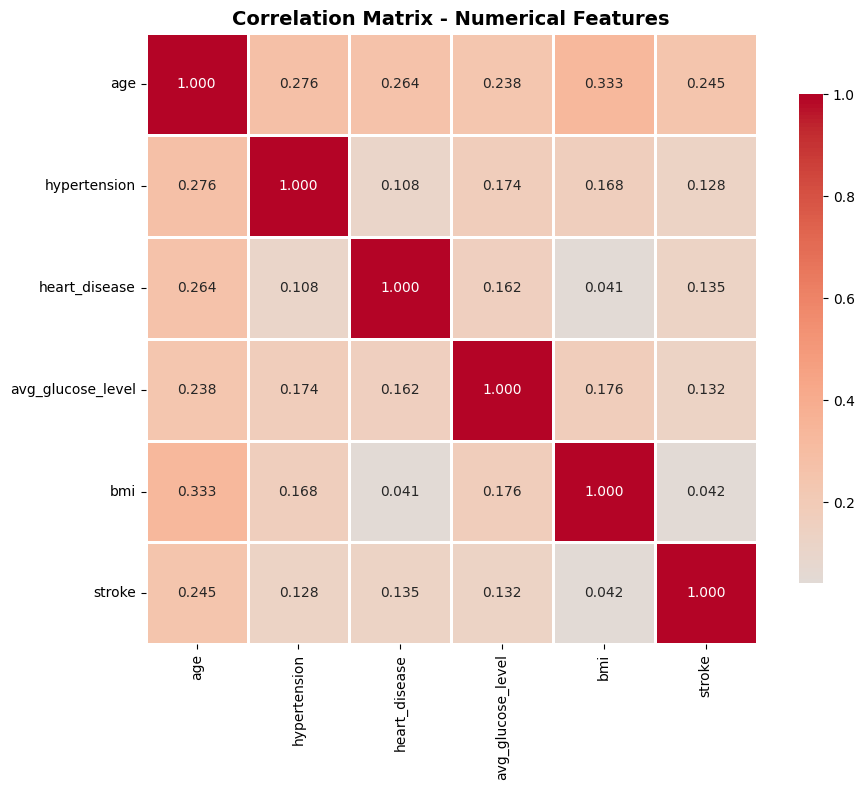


Correlations with Stroke (Target):
stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64


In [213]:
# Correlation Matrix for Numerical Features
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelations with Stroke (Target):")
print(correlation_matrix['stroke'].sort_values(ascending=False))


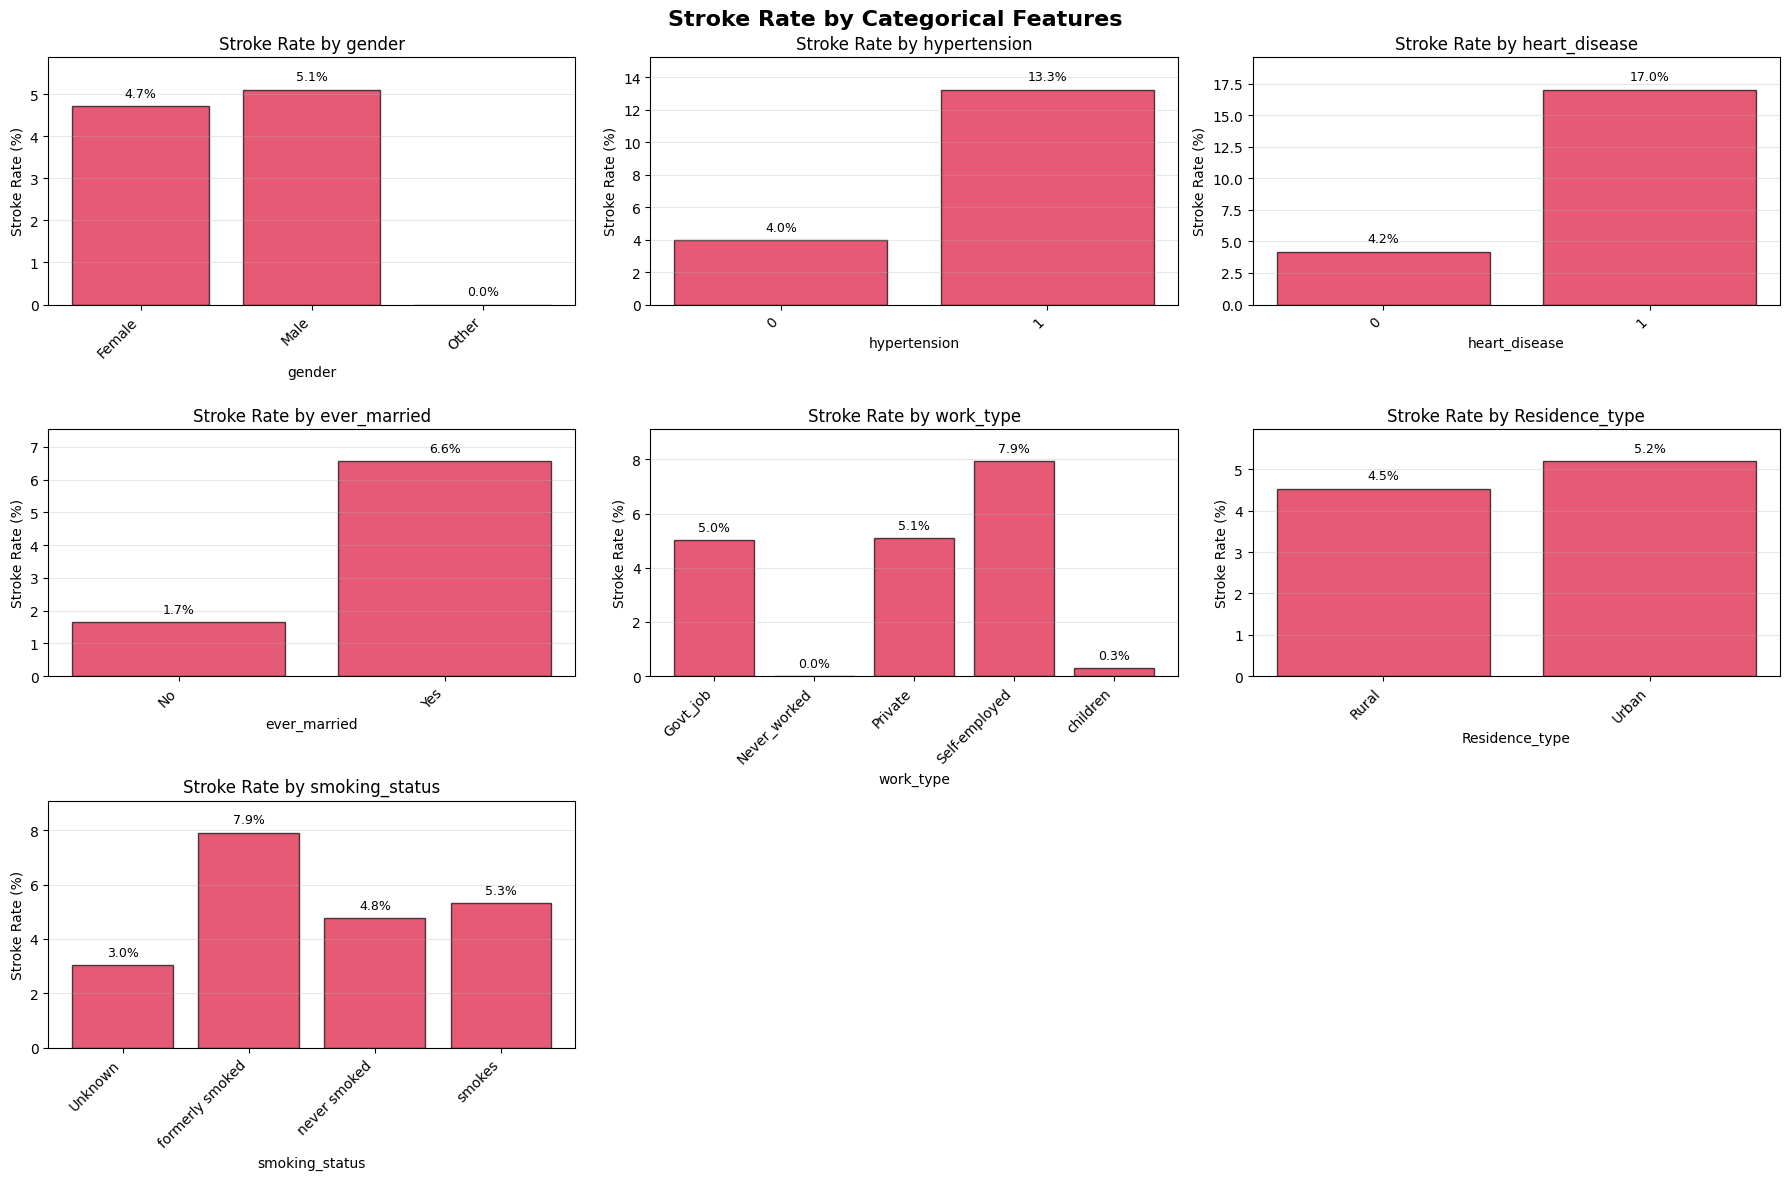

In [214]:
# Categorical Features vs Stroke 
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Stroke Rate by Categorical Features', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    # Calculate stroke rate for each category
    stroke_rate = df.groupby(feature)['stroke'].agg(['sum', 'count', 'mean'])
    stroke_rate['percentage'] = stroke_rate['mean'] * 100
    
    # Create grouped bar chart
    x = range(len(stroke_rate))
    axes[idx].bar(x, stroke_rate['percentage'], color='crimson', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Stroke Rate by {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Stroke Rate (%)')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(stroke_rate.index, rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    max_pct = stroke_rate['percentage'].max()
    for i, v in enumerate(stroke_rate['percentage']):
        axes[idx].text(i, v + max_pct * 0.03, f'{v:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Add some padding to y-axis
    axes[idx].set_ylim(0, max_pct * 1.15)

for idx in range(len(categorical_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [215]:
# Key Observations from Initial EDA
print("KEY OBSERVATIONS FROM INITIAL ANALYSIS")

print("\n1. CLASS IMBALANCE:")
print(f"   - No Stroke: {(df['stroke']==0).sum()} ({(df['stroke']==0).sum()/len(df)*100:.1f}%)")
print(f"   - Stroke: {(df['stroke']==1).sum()} ({(df['stroke']==1).sum()/len(df)*100:.1f}%)")
print("   Highly imbalanced dataset")

print("\n2. MISSING DATA:")
print(f"   - BMI has {(df['bmi'].isna().sum()/len(df)*100):.2f}% missing values (before imputation)")
print("   - All other features are complete")

print("\n3. STRONGEST CORRELATIONS WITH STROKE:")
corr_with_stroke = correlation_matrix['stroke'].drop('stroke').sort_values(ascending=False)
for feature, corr_value in corr_with_stroke.head(3).items():
    print(f"   - {feature}: {corr_value:.3f}")

print("\n4. NUMERICAL FEATURE DISTRIBUTIONS:")
print("   - Age: Right-skewed, most patients between 40-80")
print("   - Glucose: Right-skewed with some high outliers")
print("   - BMI: Approximately normal distribution")

print("\n5. CATEGORICAL FEATURE DISTRIBUTIONS:")
print(f"   - Gender: {df['gender'].value_counts()['Female']} Female ({df['gender'].value_counts()['Female']/len(df)*100:.1f}%), " +
      f"{df['gender'].value_counts()['Male']} Male ({df['gender'].value_counts()['Male']/len(df)*100:.1f}%)")
print(f"   - Hypertension: {(df['hypertension']==1).sum()} patients ({(df['hypertension']==1).sum()/len(df)*100:.1f}%) have hypertension")
print(f"   - Heart Disease: {(df['heart_disease']==1).sum()} patients ({(df['heart_disease']==1).sum()/len(df)*100:.1f}%) have heart disease")
print(f"   - Marriage: {(df['ever_married']=='Yes').sum()} patients ({(df['ever_married']=='Yes').sum()/len(df)*100:.1f}%) are married")
print(f"   - Work Type: Private sector dominates ({df['work_type'].value_counts()['Private']} patients, {df['work_type'].value_counts()['Private']/len(df)*100:.1f}%)")
print(f"   - Residence: {(df['Residence_type']=='Urban').sum()} Urban ({(df['Residence_type']=='Urban').sum()/len(df)*100:.1f}%), " +
      f"{(df['Residence_type']=='Rural').sum()} Rural ({(df['Residence_type']=='Rural').sum()/len(df)*100:.1f}%)")
smoking_counts = df['smoking_status'].value_counts()
print(f"   - Smoking Status: {smoking_counts['never smoked']} never smoked ({smoking_counts['never smoked']/len(df)*100:.1f}%), " +
      f"{smoking_counts['formerly smoked']} formerly smoked ({smoking_counts['formerly smoked']/len(df)*100:.1f}%), " +
      f"{smoking_counts['smokes']} smokes ({smoking_counts['smokes']/len(df)*100:.1f}%), " +
      f"{smoking_counts['Unknown']} unknown ({smoking_counts['Unknown']/len(df)*100:.1f}%)")

print("\n6. STROKE RISK BY CATEGORY (Key Risk Factors):")
hyp_stroke_rate = df[df['hypertension']==1]['stroke'].mean() * 100
no_hyp_stroke_rate = df[df['hypertension']==0]['stroke'].mean() * 100
heart_stroke_rate = df[df['heart_disease']==1]['stroke'].mean() * 100
no_heart_stroke_rate = df[df['heart_disease']==0]['stroke'].mean() * 100
married_stroke_rate = df[df['ever_married']=='Yes']['stroke'].mean() * 100
not_married_stroke_rate = df[df['ever_married']=='No']['stroke'].mean() * 100

print(f"   - Hypertension: {hyp_stroke_rate:.1f}% stroke rate (vs {no_hyp_stroke_rate:.1f}% without)")
print(f"   - Heart Disease: {heart_stroke_rate:.1f}% stroke rate (vs {no_heart_stroke_rate:.1f}% without)")
print(f"   - Ever Married: {married_stroke_rate:.1f}% stroke rate (vs {not_married_stroke_rate:.1f}% not married)")
print(f"   - Gender: Similar rates between Male ({df[df['gender']=='Male']['stroke'].mean()*100:.1f}%) " +
      f"and Female ({df[df['gender']=='Female']['stroke'].mean()*100:.1f}%)")
print(f"   - Smoking: formerly smoked ({df[df['smoking_status']=='formerly smoked']['stroke'].mean()*100:.1f}%), " +
      f"never smoked ({df[df['smoking_status']=='never smoked']['stroke'].mean()*100:.1f}%), " +
      f"smokes ({df[df['smoking_status']=='smokes']['stroke'].mean()*100:.1f}%), " +
      f"unknown ({df[df['smoking_status']=='Unknown']['stroke'].mean()*100:.1f}%)")

KEY OBSERVATIONS FROM INITIAL ANALYSIS

1. CLASS IMBALANCE:
   - No Stroke: 4861 (95.1%)
   - Stroke: 249 (4.9%)
   Highly imbalanced dataset

2. MISSING DATA:
   - BMI has 3.93% missing values (before imputation)
   - All other features are complete

3. STRONGEST CORRELATIONS WITH STROKE:
   - age: 0.245
   - heart_disease: 0.135
   - avg_glucose_level: 0.132

4. NUMERICAL FEATURE DISTRIBUTIONS:
   - Age: Right-skewed, most patients between 40-80
   - Glucose: Right-skewed with some high outliers
   - BMI: Approximately normal distribution

5. CATEGORICAL FEATURE DISTRIBUTIONS:
   - Gender: 2994 Female (58.6%), 2115 Male (41.4%)
   - Hypertension: 498 patients (9.7%) have hypertension
   - Heart Disease: 276 patients (5.4%) have heart disease
   - Marriage: 3353 patients (65.6%) are married
   - Work Type: Private sector dominates (2925 patients, 57.2%)
   - Residence: 2596 Urban (50.8%), 2514 Rural (49.2%)
   - Smoking Status: 1892 never smoked (37.0%), 885 formerly smoked (17.3%), 7

# Preprocessing

### Imputing Null Values

In [216]:
# KNN Imputation for null bmi values
imputer = KNNImputer(n_neighbors=5)
df[['bmi']] = imputer.fit_transform(df[['bmi']])

# Verify
null_percentage = df.isnull().mean() * 100
print(null_percentage)

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64


### Encoding Categorical Data

In [217]:
df['ever_married'] = (df['ever_married'] == 'Yes').astype(int)
df['Residence_type'] = (df['Residence_type'] == 'Urban').astype(int)

df_encoded = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], drop_first=True, dtype=int)

# Verify
df_encoded.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1,228.69,36.600000,1,1,0,0,1,0,0,1,0,0
1,61.0,0,0,1,0,202.21,28.893237,1,0,0,0,0,1,0,0,1,0
2,80.0,0,1,1,0,105.92,32.500000,1,1,0,0,1,0,0,0,1,0
3,49.0,0,0,1,1,171.23,34.400000,1,0,0,0,1,0,0,0,0,1
4,79.0,1,0,1,0,174.12,24.000000,1,0,0,0,0,1,0,0,1,0
5,81.0,0,0,1,1,186.21,29.000000,1,1,0,0,1,0,0,1,0,0
6,74.0,1,1,1,0,70.09,27.400000,1,1,0,0,1,0,0,0,1,0
7,69.0,0,0,0,1,94.39,22.800000,1,0,0,0,1,0,0,0,1,0
8,59.0,0,0,1,0,76.15,28.893237,1,0,0,0,1,0,0,0,0,0
9,78.0,0,0,1,1,58.57,24.200000,1,0,0,0,1,0,0,0,0,0


### Train-Validation-Test Split

In [218]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} ({y_train.mean()*100:.2f}% stroke)")
print(f"Val: {X_val.shape[0]} ({y_val.mean()*100:.2f}% stroke)")
print(f"Test: {X_test.shape[0]} ({y_test.mean()*100:.2f}% stroke)")

Train: 3066 (4.86% stroke)
Val: 1022 (4.89% stroke)
Test: 1022 (4.89% stroke)


### Standard Scaling


In [219]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Verify
X_train_scaled.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Male,gender_Other,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1990,-1.827461,0,0,0,1,0.134857,-1.348876,1,0,0,0,0,1,0,0,0
3840,-1.297185,0,0,0,1,-0.809394,-0.611890,0,0,0,1,0,0,1,0,0
2596,0.691353,0,0,1,0,-0.602963,0.125095,0,0,0,1,0,0,0,0,0
591,0.205266,0,0,1,1,-0.463883,0.404642,1,0,0,1,0,0,0,0,1
2975,-0.457580,0,0,1,0,0.161973,1.815080,0,0,0,1,0,0,0,1,0
2170,1.486768,0,0,1,0,-0.566443,-1.221809,0,0,0,1,0,0,0,0,0
2383,0.514594,0,0,1,0,2.756586,-0.027384,1,0,0,1,0,0,0,0,0
3230,0.072697,0,0,1,1,-0.452512,1.154334,0,0,0,1,0,0,0,1,0
4565,0.558783,0,0,1,1,-0.188349,0.468175,0,0,0,0,1,0,1,0,0
4062,1.133250,0,0,1,1,-0.330271,-0.421290,0,0,0,1,0,0,1,0,0


# Exploratory & Unsupervised Analysis

# Supervised Modeling

# Results